### Imports

In [952]:
import os
import datetime
import zipfile

from datetime import datetime

import pandas as pd
import numpy as np
from numpy import mean
from numpy import ravel
from numpy import log

import matplotlib.pyplot as plt


import sklearn
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor


import catboost as cat
from catboost import CatBoostRegressor

import xgboost
from xgboost import XGBRegressor

# Preprocessing

### Load Data

In [373]:
checks = pd.read_csv('lentahack/20210518_checks.csv')
uplift = pd.read_csv('lentahack/20210518_uplift.csv')
hierarchy = pd.read_csv('lentahack/20210518_hierarchy.csv')
offers = pd.read_csv('lentahack/20210521_offers.csv')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



KeyboardInterrupt: 

In [375]:
sample_submission = pd.read_csv('lentahack/20210521_sample_submission.csv')

### Check for NaNs

In [374]:
checks.info();
uplift.info();
hierarchy.info();
offers.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21479259 entries, 0 to 21479258
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   client_id       object 
 1   day             int64  
 2   shop_id         object 
 3   check_id        object 
 4   time            object 
 5   sku             object 
 6   promo_id        object 
 7   check_pos       int64  
 8   num_sales       float64
 9   supplier_price  float64
 10  selling_price   float64
 11  region_name     object 
dtypes: float64(3), int64(2), object(7)
memory usage: 1.9+ GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Offer_ID  740 non-null    object 
 1   UpLift    740 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80406 entries, 0 to 80405
Data columns (total 5 column

In [23]:
checks.isnull().sum()

client_id         0
day               0
shop_id           0
check_id          0
time              0
sku               0
promo_id          0
check_pos         0
num_sales         0
supplier_price    0
selling_price     0
region_name       0
dtype: int64

## Преобразуем даты

In [24]:
offers['end_date'] = [datetime.strptime(str(x), '%Y%m%d').strftime('%Y-%m-%d') for x in offers['end_date']]
offers['end_date'] = pd.to_datetime(offers['end_date'])

In [25]:
offers['start_date'] = [datetime.strptime(str(x), '%Y%m%d').strftime('%Y-%m-%d') for x in offers['start_date']]
offers['start_date'] = pd.to_datetime(offers['start_date'])

In [26]:
checks['day'] = [datetime.strptime(str(x), '%Y%m%d').strftime('%Y-%m-%d') for x in checks['day']]
checks['day'] = pd.to_datetime(checks['day'])

### Добавляем номера недель

In [27]:
checks['wk_num'] = checks['day'].dt.week

<ipython-input-27-2a1be2922755>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  checks['wk_num'] = checks['day'].dt.week


In [28]:
offers['wk_num_start'] = offers['start_date'].dt.week

<ipython-input-28-11cff2231a3e>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  offers['wk_num_start'] = offers['start_date'].dt.week


In [29]:
offers['wk_num_end'] = offers['end_date'].dt.week

<ipython-input-29-53cac88d9a4d>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  offers['wk_num_end'] = offers['end_date'].dt.week


In [30]:
offers[['wk_num_start', 'wk_num_end', 'start_date']]

,wk_num_start,wk_num_end,start_date
0,7,8,2020-02-13
1,1,2,2020-01-02
2,3,4,2020-01-16
3,12,13,2020-03-19
4,46,47,2020-11-12
...,...,...,...
9771,46,48,2019-11-14
9772,46,48,2019-11-14
9773,46,48,2019-11-14
9774,46,48,2019-11-14


## Визуализация

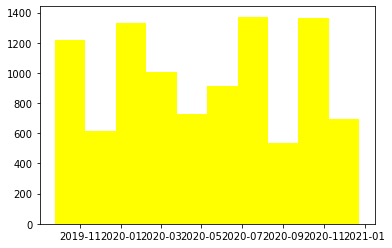

In [31]:
plt.hist(offers['start_date'], color='yellow');

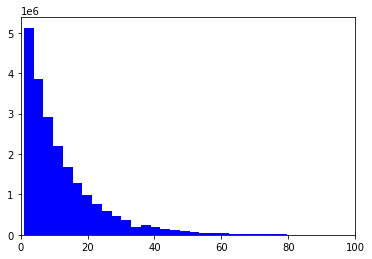

In [32]:
plt.hist(checks['check_pos'], bins = 100, color='blue')
plt.xlim(0, 100);

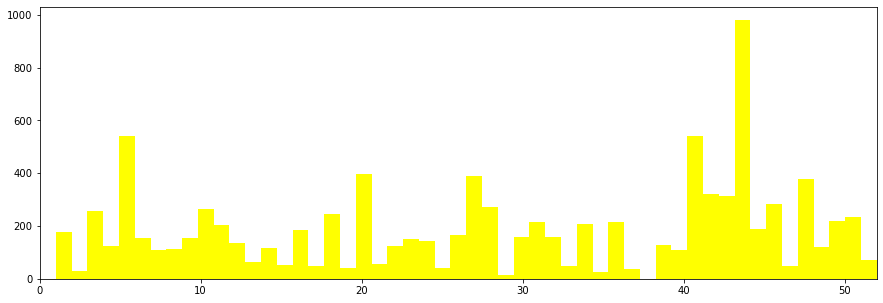

In [33]:
plt.figure(figsize = (15,5))
plt.hist(offers['wk_num_start'], bins=52, color='yellow')
plt.xlim(0,52);

(0.0, 52.0)

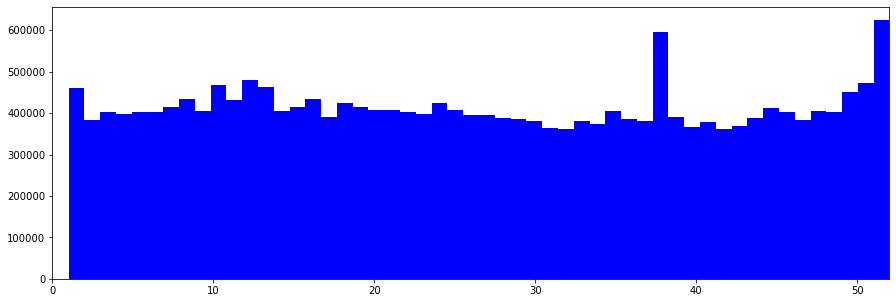

In [34]:
plt.figure(figsize = (15,5))
plt.hist(checks['wk_num'], bins=52, color='blue')
plt.xlim(0,52)

## Feature Engineering

### Merging dataset for Feature Engineering

In [35]:
result = pd.merge(checks, offers, on='sku', how='outer')

In [36]:
result['date_check'] = np.where((result['day'] < result['end_date'])&(result['day'] > result['start_date']), 1, 0)

In [37]:
result_day_check = result[result['date_check']==1]

In [38]:
result_test = result[result['train_test_group']=='test']

In [39]:
full_data[full_data['train_test_group'] == 'train']

,Offer_ID,"('delta_time_x', 'mean')",Promo_type,avg_promo_type,sku,"('delta_time', 'mean')_y","('num_sales', 'mean')","('delta_price', 'mean')",client_id,day,...,hierarchy_level1,hierarchy_level2,hierarchy_level3,hierarchy_level4,price_for_1_item_supply,price_for_1_item,delta_price,log_delta_price,delta_time_y,holiday
0,10,14,Biweekly,119.729423,172239f5f436f6b6661fdaa10fb47e9f,12.988889,1.211111,19.487579,ac78b904ae23f9315c42baaf2c6f6d85,2020-04-11,...,cc9284597026dcc021735c0970ca0c93,6364d3f0f495b6ab9dcf8d3b5c6e0b01,7486cef2522ee03547cfb970a404a874,3f6ab5dd77f73b11f122ac7c0fe2de76,28.520000,49.390000,20.870000,3.038313,14,1
1,10,14,Biweekly,119.729423,172239f5f436f6b6661fdaa10fb47e9f,12.988889,1.211111,19.487579,be8f09b332f748369488203649fad52f,2020-04-11,...,cc9284597026dcc021735c0970ca0c93,6364d3f0f495b6ab9dcf8d3b5c6e0b01,7486cef2522ee03547cfb970a404a874,3f6ab5dd77f73b11f122ac7c0fe2de76,29.410000,49.390000,19.980000,2.994732,14,1
2,10,14,Biweekly,119.729423,172239f5f436f6b6661fdaa10fb47e9f,12.988889,1.211111,19.487579,71593227402b68fa7b99b1da22420eca,2020-04-11,...,cc9284597026dcc021735c0970ca0c93,6364d3f0f495b6ab9dcf8d3b5c6e0b01,7486cef2522ee03547cfb970a404a874,3f6ab5dd77f73b11f122ac7c0fe2de76,28.760000,49.390000,20.630000,3.026746,14,1
3,10,14,Biweekly,119.729423,172239f5f436f6b6661fdaa10fb47e9f,12.988889,1.211111,19.487579,c2e6a44a05ca209b87afd3cf0a4f1cba,2020-04-11,...,cc9284597026dcc021735c0970ca0c93,6364d3f0f495b6ab9dcf8d3b5c6e0b01,7486cef2522ee03547cfb970a404a874,3f6ab5dd77f73b11f122ac7c0fe2de76,28.582500,49.390000,20.807500,3.035313,14,1
4,10,14,Biweekly,119.729423,172239f5f436f6b6661fdaa10fb47e9f,12.988889,1.211111,19.487579,78edd48645b93587a36031cc591206b6,2020-04-11,...,cc9284597026dcc021735c0970ca0c93,6364d3f0f495b6ab9dcf8d3b5c6e0b01,7486cef2522ee03547cfb970a404a874,3f6ab5dd77f73b11f122ac7c0fe2de76,28.530000,49.390000,20.860000,3.037833,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988203,F99,7,Facades,139.913314,6be0907d36fbbf5f7378f32c46f37943,7.000000,1.707708,7.431893,d460b589b0704c4f2432c6e2f0a42b6e,2020-06-22,...,cc9284597026dcc021735c0970ca0c93,9bf31c7ff062936a96d3c8bd1f8f2ff3,5cbdfd0dfa22a3fca7266376887f549b,a02809f6be582b792d4057f9d7e1c40e,19.701355,29.993842,10.292488,2.331414,7,1
988204,F99,7,Facades,139.913314,6be0907d36fbbf5f7378f32c46f37943,7.000000,1.707708,7.431893,d5fabe976082d2d65440aee8b110e732,2020-06-22,...,cc9284597026dcc021735c0970ca0c93,9bf31c7ff062936a96d3c8bd1f8f2ff3,5cbdfd0dfa22a3fca7266376887f549b,a02809f6be582b792d4057f9d7e1c40e,19.702797,29.991259,10.288462,2.331023,7,1
988205,F99,7,Facades,139.913314,6be0907d36fbbf5f7378f32c46f37943,7.000000,1.707708,7.431893,d798a6107201e11453b1d9f999eb0847,2020-06-22,...,cc9284597026dcc021735c0970ca0c93,9bf31c7ff062936a96d3c8bd1f8f2ff3,5cbdfd0dfa22a3fca7266376887f549b,a02809f6be582b792d4057f9d7e1c40e,19.697368,30.000000,10.302632,2.332399,7,1
988206,F99,7,Facades,139.913314,6be0907d36fbbf5f7378f32c46f37943,7.000000,1.707708,7.431893,2777528dd5e8a8119b2222f69f70c96c,2020-06-22,...,cc9284597026dcc021735c0970ca0c93,9bf31c7ff062936a96d3c8bd1f8f2ff3,5cbdfd0dfa22a3fca7266376887f549b,a02809f6be582b792d4057f9d7e1c40e,26.580756,29.991409,3.410653,1.226904,7,1


In [40]:
full_data = pd.merge(result_day_check , hierarchy, how='inner',on=['sku'])
full_data

,client_id,day,shop_id,check_id,time,sku,promo_id,check_pos,num_sales,supplier_price,...,start_date,end_date,train_test_group,wk_num_start,wk_num_end,date_check,hierarchy_level1,hierarchy_level2,hierarchy_level3,hierarchy_level4
0,f5883bc2315398454cef231404da81ee,2020-03-27,d39934ce111a864abf40391f3da9cdf5,6b4d6d3a10deb5788eafca73c0e795fd,13:01:11,b9ef00e971d0fb459a765708efba70c0,1de8ed0a82fc39796d11da89ee86d607,46,1.0,96.77,...,2020-03-19,2020-04-01,train,12.0,14.0,1,44a7b825383402ed937a15fb8a5bb12a,d645920e395fedad7bbbed0eca3fe2e0,6693a7aacb8a2e74c6f5fe91bc39864b,878b4140ebdb1b79f378d2cf0cc3245c
1,62823feeae170ce71a3787c203d8a718,2020-03-27,d39934ce111a864abf40391f3da9cdf5,4cec157ad32ea17bf0a3e4178019b990,15:15:53,b9ef00e971d0fb459a765708efba70c0,1de8ed0a82fc39796d11da89ee86d607,1,1.0,96.77,...,2020-03-19,2020-04-01,train,12.0,14.0,1,44a7b825383402ed937a15fb8a5bb12a,d645920e395fedad7bbbed0eca3fe2e0,6693a7aacb8a2e74c6f5fe91bc39864b,878b4140ebdb1b79f378d2cf0cc3245c
2,073aa4b0edc4617c62c302aaf791a7cb,2020-03-27,d39934ce111a864abf40391f3da9cdf5,502843a48b0fc49f4acc134a7f0c03cd,08:00:35,b9ef00e971d0fb459a765708efba70c0,1de8ed0a82fc39796d11da89ee86d607,14,1.0,96.77,...,2020-03-19,2020-04-01,train,12.0,14.0,1,44a7b825383402ed937a15fb8a5bb12a,d645920e395fedad7bbbed0eca3fe2e0,6693a7aacb8a2e74c6f5fe91bc39864b,878b4140ebdb1b79f378d2cf0cc3245c
3,9925f967444c9cee55518b25ee7a116a,2020-03-27,d39934ce111a864abf40391f3da9cdf5,d973669af03fca24d481b7b28d0256e9,20:51:32,b9ef00e971d0fb459a765708efba70c0,1de8ed0a82fc39796d11da89ee86d607,24,1.0,96.77,...,2020-03-19,2020-04-01,train,12.0,14.0,1,44a7b825383402ed937a15fb8a5bb12a,d645920e395fedad7bbbed0eca3fe2e0,6693a7aacb8a2e74c6f5fe91bc39864b,878b4140ebdb1b79f378d2cf0cc3245c
4,cd6e626e2303c8c34c2b411d974a066a,2020-03-27,d39934ce111a864abf40391f3da9cdf5,3ba293abef2c1328081ccb6bc88524df,16:12:32,b9ef00e971d0fb459a765708efba70c0,1de8ed0a82fc39796d11da89ee86d607,1,1.0,96.77,...,2020-03-19,2020-04-01,train,12.0,14.0,1,44a7b825383402ed937a15fb8a5bb12a,d645920e395fedad7bbbed0eca3fe2e0,6693a7aacb8a2e74c6f5fe91bc39864b,878b4140ebdb1b79f378d2cf0cc3245c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988203,7f61d5a3e51b1f565c1a7e9babc6ea82,2020-08-12,5394c8765bf72ecb92711a1e6f9b8783,fb9f01c83e1ec864c7a89f23cabe1cc2,16:40:36,80047755fdd5c6459ed2c4f734c190e4,792172eaeacc7979a5d0f50359d13322,21,1.0,206.14,...,2020-07-28,2020-09-01,train,31.0,36.0,1,44a7b825383402ed937a15fb8a5bb12a,2838023a778dfaecdc212708f721b788,2c26f9a59b0ba61233e6fc0af8e47f14,e2c7a001428c33b71d08b54f254e0997
988204,8ad501db6e0f885585b2e0dfa0e68d13,2020-08-19,d33f67c5652acb3fac99b9dc16bea0c1,99281b4fedff4c7d1f393ab80736b90d,11:20:05,80047755fdd5c6459ed2c4f734c190e4,792172eaeacc7979a5d0f50359d13322,12,1.0,206.14,...,2020-07-28,2020-09-01,train,31.0,36.0,1,44a7b825383402ed937a15fb8a5bb12a,2838023a778dfaecdc212708f721b788,2c26f9a59b0ba61233e6fc0af8e47f14,e2c7a001428c33b71d08b54f254e0997
988205,fb704ef73f277eeff1154e7a8112941c,2020-06-28,29549a71a57f587d88209b9c1f1b7999,b5b9528029645c816ec2bc6858657855,15:21:39,9fe155a9e4f9402ba8728916a35a162e,883319be348e4a942d64134fbbbaf055,49,1.0,125.40,...,2020-06-25,2020-07-08,train,26.0,28.0,1,44a7b825383402ed937a15fb8a5bb12a,9a1158154dfa42caddbd0694a4e9bdc8,f50c7035e532c49a0f6993d988e2e843,c134be80fec34c5b05f7464154900af8
988206,92059eef9d756f18e83007f18f24edce,2019-11-19,7f8bb0fe8b33780a08fe6b60ced14529,0b267b26e0df89783a6daf0267db9ce6,14:01:48,8f281d4e115c3f13fb505a707b557fd3,9b8f3613add370c85ef0cf913264529a,1,1.0,218.54,...,2019-11-05,2019-11-25,train,45.0,48.0,1,44a7b825383402ed937a15fb8a5bb12a,44f683a84163b3523afe57c2e008bc8c,e0cd3f16f9e883ca91c2a4c24f47b3d9,eb9c88a76c4cdcdca51b382e20878780


## Generating new features

In [41]:
full_data['supplier_price_for_1_sku_unit'] = full_data['supplier_price']/full_data['num_sales']

In [42]:
full_data['selling_price_for_1_sku_unit'] = full_data['selling_price']/full_data['num_sales']

In [43]:
full_data['delta_price'] = full_data['selling_price_for_1_sku_unit'] - full_data['supplier_price_for_1_sku_unit']

In [44]:
full_data['delta_time'] = full_data['end_date'] - full_data['start_date']

In [45]:
full_data['delta_time'] = full_data['delta_time'].astype('timedelta64[D]').astype(int) + 1

In [46]:
full_data_for_sku_unit_price=full_data.groupby(["Promo_type"]).agg({
  "selling_price": "sum",
  "num_sales": "count"

}).reset_index()
full_data_for_sku_unit_price['sku_unit_price_per_promo_type'] = full_data_for_sku_unit_price['selling_price']/full_data_for_sku_unit_price['num_sales']

In [47]:
full_data = pd.merge(full_data_for_sku_unit_price[['Promo_type', 'sku_unit_price_per_promo_type']],full_data, how='outer',on=['Promo_type'])

In [48]:
for_delta_mean_price_by_sku = full_data.groupby("sku").agg({"delta_price": [np.mean]})
full_data=pd.merge(for_delta_mean_price_by_sku, full_data, how='inner',on=['sku'])

/anaconda/envs/py38_default/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [49]:
for_mean_num_sales = full_data.groupby("sku").agg({"num_sales": [np.mean]})
full_data = pd.merge(for_mean_num_sales, full_data, how='inner',on=['sku'])

In [50]:
for_mean_delta_time = full_data.groupby("sku").agg({"delta_time": [np.mean]})
full_data=pd.merge(for_mean_delta_time,full_data, how='inner',on=['sku'])

In [51]:
full_data.columns

Index([                          'sku',          ('delta_time', 'mean'),
                 ('num_sales', 'mean'),         ('delta_price', 'mean'),
                          'Promo_type', 'sku_unit_price_per_promo_type',
                           'client_id',                           'day',
                             'shop_id',                      'check_id',
                                'time',                      'promo_id',
                           'check_pos',                     'num_sales',
                      'supplier_price',                 'selling_price',
                         'region_name',                        'wk_num',
                            'Offer_ID',                    'start_date',
                            'end_date',              'train_test_group',
                        'wk_num_start',                    'wk_num_end',
                          'date_check',              'hierarchy_level1',
                    'hierarchy_level2',            

## Merging offers with new featurs and Uplift

In [192]:
full_data1 = pd.read_csv('full_data1.csv')
full_data1

/anaconda/envs/py38_default/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Offer_ID,promo_type_delta_time_mean,Promo_type,avg_promo_type,sku,sku_delta_time_mean,sku_num_sales_mean,sku_delta_price_mean,client_id,day,...,hierarchy_level1,hierarchy_level2,hierarchy_level3,hierarchy_level4,price_for_1_item_supply,price_for_1_item,delta_price,log_delta_price,delta_time_y,holiday
0,10,14,Biweekly,119.729423,172239f5f436f6b6661fdaa10fb47e9f,12.988889,1.211111,19.487579,ac78b904ae23f9315c42baaf2c6f6d85,2020-04-11,...,cc9284597026dcc021735c0970ca0c93,6364d3f0f495b6ab9dcf8d3b5c6e0b01,7486cef2522ee03547cfb970a404a874,3f6ab5dd77f73b11f122ac7c0fe2de76,28.520000,49.390000,20.870000,3.038313,14,1
1,10,14,Biweekly,119.729423,172239f5f436f6b6661fdaa10fb47e9f,12.988889,1.211111,19.487579,be8f09b332f748369488203649fad52f,2020-04-11,...,cc9284597026dcc021735c0970ca0c93,6364d3f0f495b6ab9dcf8d3b5c6e0b01,7486cef2522ee03547cfb970a404a874,3f6ab5dd77f73b11f122ac7c0fe2de76,29.410000,49.390000,19.980000,2.994732,14,1
2,10,14,Biweekly,119.729423,172239f5f436f6b6661fdaa10fb47e9f,12.988889,1.211111,19.487579,71593227402b68fa7b99b1da22420eca,2020-04-11,...,cc9284597026dcc021735c0970ca0c93,6364d3f0f495b6ab9dcf8d3b5c6e0b01,7486cef2522ee03547cfb970a404a874,3f6ab5dd77f73b11f122ac7c0fe2de76,28.760000,49.390000,20.630000,3.026746,14,1
3,10,14,Biweekly,119.729423,172239f5f436f6b6661fdaa10fb47e9f,12.988889,1.211111,19.487579,c2e6a44a05ca209b87afd3cf0a4f1cba,2020-04-11,...,cc9284597026dcc021735c0970ca0c93,6364d3f0f495b6ab9dcf8d3b5c6e0b01,7486cef2522ee03547cfb970a404a874,3f6ab5dd77f73b11f122ac7c0fe2de76,28.582500,49.390000,20.807500,3.035313,14,1
4,10,14,Biweekly,119.729423,172239f5f436f6b6661fdaa10fb47e9f,12.988889,1.211111,19.487579,78edd48645b93587a36031cc591206b6,2020-04-11,...,cc9284597026dcc021735c0970ca0c93,6364d3f0f495b6ab9dcf8d3b5c6e0b01,7486cef2522ee03547cfb970a404a874,3f6ab5dd77f73b11f122ac7c0fe2de76,28.530000,49.390000,20.860000,3.037833,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988203,F99,7,Facades,139.913314,6be0907d36fbbf5f7378f32c46f37943,7.000000,1.707708,7.431893,d460b589b0704c4f2432c6e2f0a42b6e,2020-06-22,...,cc9284597026dcc021735c0970ca0c93,9bf31c7ff062936a96d3c8bd1f8f2ff3,5cbdfd0dfa22a3fca7266376887f549b,a02809f6be582b792d4057f9d7e1c40e,19.701355,29.993842,10.292488,2.331414,7,1
988204,F99,7,Facades,139.913314,6be0907d36fbbf5f7378f32c46f37943,7.000000,1.707708,7.431893,d5fabe976082d2d65440aee8b110e732,2020-06-22,...,cc9284597026dcc021735c0970ca0c93,9bf31c7ff062936a96d3c8bd1f8f2ff3,5cbdfd0dfa22a3fca7266376887f549b,a02809f6be582b792d4057f9d7e1c40e,19.702797,29.991259,10.288462,2.331023,7,1
988205,F99,7,Facades,139.913314,6be0907d36fbbf5f7378f32c46f37943,7.000000,1.707708,7.431893,d798a6107201e11453b1d9f999eb0847,2020-06-22,...,cc9284597026dcc021735c0970ca0c93,9bf31c7ff062936a96d3c8bd1f8f2ff3,5cbdfd0dfa22a3fca7266376887f549b,a02809f6be582b792d4057f9d7e1c40e,19.697368,30.000000,10.302632,2.332399,7,1
988206,F99,7,Facades,139.913314,6be0907d36fbbf5f7378f32c46f37943,7.000000,1.707708,7.431893,2777528dd5e8a8119b2222f69f70c96c,2020-06-22,...,cc9284597026dcc021735c0970ca0c93,9bf31c7ff062936a96d3c8bd1f8f2ff3,5cbdfd0dfa22a3fca7266376887f549b,a02809f6be582b792d4057f9d7e1c40e,26.580756,29.991409,3.410653,1.226904,7,1


In [193]:
full_agg = full_data1.groupby(["Promo_type", "sku"]).mean()
#.agg({"num_sales": [np.mean]})

In [194]:
full_agg

promo_type_delta_time_mean  \
Promo_type sku                                                            
Billboards 00218695e83d28a79151ef327e51200c                   14.000000   
           006ed8661c6a2060c0ade85ef8ab26d0                   14.000000   
           0095649b699a27c83754b90415faa9a6                   14.000000   
           01e6467e21269b674df08c4aee06c503                   14.000000   
           03ee197f2befaccf999e84952e6983cd                   14.000000   
...                                                                 ...   
Seasonal   ff608c85ac3bd4ca8568b28746d86ee7                   15.050000   
           ff6806b34403247f7d2429b9dac2eff3                   17.043478   
           ff9bf520af5f68d957aa193977ec8b85                   18.000000   
           ffb361905f5828922df2edcc7d50d3b8                   22.000000   
           ffd28420812333369041b2434a483ee8                   28.000000   

                                             avg_promo_type  \
Promo_type sku                                                
Billboards 00218695e83d28a79151ef327e51200c      216.134721   
           006ed8661c6a2060c0ade85ef8ab26d0      216.134721   
           0095649b699a27c83754b90415faa9a6      216.134721   
           01e6467e21269b674df08c4aee06c503      216.134721   
           03ee197f2befaccf999e84952e6983cd      216.134721   
...                                                     ...   
Seasonal   ff608c85ac3bd4ca8568b28746d86ee7      156.421841   
           ff6806b34403247f7d2429b9dac2eff3      156.421841   
           ff9bf520af5f68d957aa193977ec8b85      156.421841   
           ffb361905f5828922df2edcc7d50d3b8      156.421841   
           ffd28420812333369041b2434a483ee8      156.421841   

                                             sku_delta_time_mean  \
Promo_type sku                                                     
Billboards 00218695e83d28a79151ef327e51200c            14.000000   
           006ed8661c6a2060c0ade85ef8ab26d0            14.000000   
           0095649b699a27c83754b90415faa9a6            14.000000   
           01e6467e21269b674df08c4aee06c503            14.000000   
           03ee197f2befaccf999e84952e6983cd            14.000000   
...                                                          ...   
Seasonal   ff608c85ac3bd4ca8568b28746d86ee7            13.781250   
           ff6806b34403247f7d2429b9dac2eff3            15.408805   
           ff9bf520af5f68d957aa193977ec8b85            18.000000   
           ffb361905f5828922df2edcc7d50d3b8            22.000000   
           ffd28420812333369041b2434a483ee8            28.000000   

                                             sku_num_sales_mean  \
Promo_type sku                                                    
Billboards 00218695e83d28a79151ef327e51200c            1.034483   
           006ed8661c6a2060c0ade85ef8ab26d0            1.206699   
           0095649b699a27c83754b90415faa9a6            1.000000   
           01e6467e21269b674df08c4aee06c503            1.257426   
           03ee197f2befaccf999e84952e6983cd            1.016667   
...                                                         ...   
Seasonal   ff608c85ac3bd4ca8568b28746d86ee7            1.031250   
           ff6806b34403247f7d2429b9dac2eff3            1.150943   
           ff9bf520af5f68d957aa193977ec8b85            1.000000   
           ffb361905f5828922df2edcc7d50d3b8            1.000000   
           ffd28420812333369041b2434a483ee8            1.981154   

                                             sku_delta_price_mean  check_pos  \
Promo_type sku                                                                 
Billboards 00218695e83d28a79151ef327e51200c            -31.269741  26.866667   
           006ed8661c6a2060c0ade85ef8ab26d0             10.647752  12.317972   
           0095649b699a27c83754b90415faa9a6            -27.155714  10.400000   
           01e6467e21269b674df08c4aee06c503              8.004640  15.061947   
           0

In [195]:
full_agg1 = full_data1.groupby(["sku"]).mean()

In [196]:
full_agg1

,promo_type_delta_time_mean,avg_promo_type,sku_delta_time_mean,sku_num_sales_mean,sku_delta_price_mean,check_pos,num_sales,supplier_price,selling_price,wk_num,date_check,wk_num_start,wk_num_end,price_for_1_item_supply,price_for_1_item,delta_price,log_delta_price,delta_time_y,holiday
sku,,,,,,,,,,,,,,,,,,,
00104b38b0b48f14e6b94c294a91356b,15.090295,156.421841,15.090295,1.109705,30.908270,11.531646,1.109705,86.686371,121.000152,19.983122,1.0,19.195781,21.511392,78.142970,109.051241,30.908270,3.411013,15.090295,1.0
00218695e83d28a79151ef327e51200c,14.000000,151.807090,14.000000,1.034483,-31.269741,14.560345,1.034483,202.755431,170.378017,20.379310,1.0,19.655172,21.655172,196.089052,164.819310,-31.269741,2.626840,14.000000,1.0
002efbd1c274c4d3dd21e48787124a93,14.000000,119.729423,14.000000,1.000000,200.279412,4.882353,1.000000,798.340000,998.619412,28.705882,1.0,28.000000,30.000000,798.340000,998.619412,200.279412,5.299712,14.000000,1.0
00432d021eca6059fee2ed69a732c2b2,13.413793,121.419700,13.413793,1.266010,11.659492,10.615764,1.266010,57.410181,72.127159,21.333333,1.0,20.541872,22.458128,45.387634,57.047126,11.659492,2.421337,13.413793,1.0
00581113943ffd4c16964dd1b545044f,14.000000,156.421841,14.000000,1.044444,10.795926,12.377778,1.044444,77.755333,89.179111,15.111111,1.0,14.600000,16.600000,74.516963,85.312889,10.795926,2.590615,14.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff9bf520af5f68d957aa193977ec8b85,18.000000,156.421841,18.000000,1.000000,16.428571,26.285714,1.000000,56.847143,73.275714,16.857143,1.0,16.142857,18.714286,56.847143,73.275714,16.428571,2.654500,18.000000,1.0
ffb361905f5828922df2edcc7d50d3b8,22.000000,156.421841,22.000000,1.000000,250.043793,10.448276,1.000000,549.507241,799.551034,14.000000,1.0,13.000000,16.000000,549.507241,799.551034,250.043793,5.520308,22.000000,1.0
ffd28420812333369041b2434a483ee8,28.000000,156.421841,28.000000,1.981154,18.234056,11.129564,1.981154,46.073545,82.278775,24.667845,1.0,23.000000,27.000000,23.256863,41.490919,18.234056,2.900410,28.000000,1.0


In [197]:
offers_uplift = pd.merge(offers, uplift, how='left', on='Offer_ID')
offers_uplift_test = offers_uplift[offers_uplift['train_test_group'] == 'test']

In [198]:
offers_uplift_test = offers_uplift_test.drop('UpLift', axis=1)

In [199]:
offers_uplift_test

,Promo_type,Offer_ID,sku,start_date,end_date,train_test_group,wk_num_start,wk_num_end
4,Facades,F191,e87788b585ead792a4d40f7de18f2f76,2020-11-12,2020-11-18,test,46,47
6,Billboards,B86,cdab3403355b7fda81a1329b2f05cdec,2020-10-29,2020-11-11,test,44,46
18,Facades,F172,723dad25536c2cf3fb4fd3f577ee2b7c,2020-10-15,2020-10-21,test,42,43
23,Billboards,B96,9817112604594b376adf135efe787bbc,2020-12-03,2020-12-09,test,49,50
26,Facades,F173,b8169608d99f3a31891379d394735732,2020-10-14,2020-10-21,test,42,43
...,...,...,...,...,...,...,...,...
7861,Seasonal,99,fc2fe174d3547a2d077bb94742977bdb,2020-10-06,2020-10-19,test,41,43
8003,Billboards,B140,7a8675a8f6988ebcbefd062fabaccc85,2020-12-24,2020-12-30,test,52,53
8004,Billboards,B140,787762f7d829ce318599bf015baba175,2020-12-24,2020-12-30,test,52,53
8008,Billboards,B140,c8ac520562ba934dd67cbf0f060c4252,2020-12-24,2020-12-30,test,52,53


In [200]:
offers_uplift_test_hier = pd.merge(offers_uplift_test, hierarchy, how='left', on='sku')

In [201]:
offers_uplift_test_hier

,Promo_type,Offer_ID,sku,start_date,end_date,train_test_group,wk_num_start,wk_num_end,hierarchy_level1,hierarchy_level2,hierarchy_level3,hierarchy_level4
0,Facades,F191,e87788b585ead792a4d40f7de18f2f76,2020-11-12,2020-11-18,test,46,47,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,3341f6f048384ec73a7ba2e77d2db48b,ee087215b0e0761bc986abd837ac7ab7
1,Billboards,B86,cdab3403355b7fda81a1329b2f05cdec,2020-10-29,2020-11-11,test,44,46,cc9284597026dcc021735c0970ca0c93,6364d3f0f495b6ab9dcf8d3b5c6e0b01,7486cef2522ee03547cfb970a404a874,3f6ab5dd77f73b11f122ac7c0fe2de76
2,Facades,F172,723dad25536c2cf3fb4fd3f577ee2b7c,2020-10-15,2020-10-21,test,42,43,cc9284597026dcc021735c0970ca0c93,182be0c5cdcd5072bb1864cdee4d3d6e,f24ad6f72d6cc4cb51464f2b29ab69d3,8b87d89c20466be32b28ceab1fb99830
3,Billboards,B96,9817112604594b376adf135efe787bbc,2020-12-03,2020-12-09,test,49,50,cc9284597026dcc021735c0970ca0c93,34173cb38f07f89ddbebc2ac9128303f,3a61ed715ee66c48bacf237fa7bb5289,5857f9a37e5fcb411183541a8bc250d0
4,Facades,F173,b8169608d99f3a31891379d394735732,2020-10-14,2020-10-21,test,42,43,44a7b825383402ed937a15fb8a5bb12a,d645920e395fedad7bbbed0eca3fe2e0,f8eb278a8bce873ef365b45e939da38a,dc34a0d2fb7489f32d32e0e0e23f9d44
...,...,...,...,...,...,...,...,...,...,...,...,...
2055,Seasonal,99,fc2fe174d3547a2d077bb94742977bdb,2020-10-06,2020-10-19,test,41,43,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,3341f6f048384ec73a7ba2e77d2db48b,44ffc63b904a643b73198d4c72d95473
2056,Billboards,B140,7a8675a8f6988ebcbefd062fabaccc85,2020-12-24,2020-12-30,test,52,53,cc9284597026dcc021735c0970ca0c93,6512bd43d9caa6e02c990b0a82652dca,c667d53acd899a97a85de0c201ba99be,5f958aa50f12213d724b476ac436a658
2057,Billboards,B140,787762f7d829ce318599bf015baba175,2020-12-24,2020-12-30,test,52,53,cc9284597026dcc021735c0970ca0c93,c20ad4d76fe97759aa27a0c99bff6710,fb2fcd534b0ff3bbed73cc51df620323,c005b9a2626f6c1946e1851628724b18
2058,Billboards,B140,c8ac520562ba934dd67cbf0f060c4252,2020-12-24,2020-12-30,test,52,53,cc9284597026dcc021735c0970ca0c93,c20ad4d76fe97759aa27a0c99bff6710,7501e5d4da87ac39d782741cd794002d,1bc92b99fd45cc2e89907ad2770c2746


In [202]:
new_features = [#'sku',
                #'Promo_type',
                #'hierarchy_level1',
                #'hierarchy_level2',
                #'hierarchy_level3',
                #'hierarchy_level4',
                'promo_type_delta_time_mean', 
                'avg_promo_type',
                'sku_delta_time_mean', 
                'sku_num_sales_mean',
                'sku_delta_price_mean', 
                #'if_promo',  
                'price_for_1_item_supply',
                'price_for_1_item', 
                'delta_price', 
                'log_delta_price', 
                'delta_time_y',
                'holiday']
                

In [203]:
offers_uplift_test_hier = pd.merge(offers_uplift_test_hier, full_agg[new_features], how='left', on=['Promo_type', 'sku'])

In [204]:
offers_uplift_test_hier.columns

Index(['Promo_type', 'Offer_ID', 'sku', 'start_date', 'end_date',
       'train_test_group', 'wk_num_start', 'wk_num_end', 'hierarchy_level1',
       'hierarchy_level2', 'hierarchy_level3', 'hierarchy_level4',
       'promo_type_delta_time_mean', 'avg_promo_type', 'sku_delta_time_mean',
       'sku_num_sales_mean', 'sku_delta_price_mean', 'price_for_1_item_supply',
       'price_for_1_item', 'delta_price', 'log_delta_price', 'delta_time_y',
       'holiday'],
      dtype='object')

In [205]:
offers_uplift_test_hier.isnull().sum()

Promo_type                       0
Offer_ID                         0
sku                              0
start_date                       0
end_date                         0
train_test_group                 0
wk_num_start                     0
wk_num_end                       0
hierarchy_level1                 0
hierarchy_level2                 0
hierarchy_level3                 0
hierarchy_level4                 0
promo_type_delta_time_mean     776
avg_promo_type                 776
sku_delta_time_mean            776
sku_num_sales_mean             776
sku_delta_price_mean           776
price_for_1_item_supply        776
price_for_1_item               776
delta_price                    776
log_delta_price               1196
delta_time_y                   776
holiday                        776
dtype: int64

In [206]:
offers_uplift_test_hier_bysku = offers_uplift_test_hier[offers_uplift_test_hier['promo_type_delta_time_mean'].isnull()]

In [207]:
offers_uplift_test_hier_bysku

,Promo_type,Offer_ID,sku,start_date,end_date,train_test_group,wk_num_start,wk_num_end,hierarchy_level1,hierarchy_level2,...,avg_promo_type,sku_delta_time_mean,sku_num_sales_mean,sku_delta_price_mean,price_for_1_item_supply,price_for_1_item,delta_price,log_delta_price,delta_time_y,holiday
1,Billboards,B86,cdab3403355b7fda81a1329b2f05cdec,2020-10-29,2020-11-11,test,44,46,cc9284597026dcc021735c0970ca0c93,6364d3f0f495b6ab9dcf8d3b5c6e0b01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Facades,F173,b8169608d99f3a31891379d394735732,2020-10-14,2020-10-21,test,42,43,44a7b825383402ed937a15fb8a5bb12a,d645920e395fedad7bbbed0eca3fe2e0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Billboards,B88,06ab1c0bfb37a28e3aa7f643ff85ab88,2020-11-05,2020-11-11,test,45,46,cc9284597026dcc021735c0970ca0c93,6f4922f45568161a8cdf4ad2299f6d23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,Billboards,B88,85249fe8374a7267e5d3f1c63efae931,2020-11-05,2020-11-11,test,45,46,cc9284597026dcc021735c0970ca0c93,6f4922f45568161a8cdf4ad2299f6d23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,Facades,F164,94e50bb3c768a677fe0c7f07047514ff,2020-10-08,2020-10-14,test,41,42,cc9284597026dcc021735c0970ca0c93,19ca14e7ea6328a42e0eb13d585e4c22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049,Seasonal,99,eac9776796c22d36801ca6bef05384f9,2020-10-06,2020-10-19,test,41,43,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2050,Seasonal,99,7a40c741ff3cc771e87320fa0831869f,2020-10-06,2020-10-19,test,41,43,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2052,Seasonal,99,a827742fafcd933d784fa8514f4aa147,2020-10-06,2020-10-19,test,41,43,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2054,Biweekly,535,c22f24d440d089f13edaac2d5a782be3,2020-10-29,2020-11-11,test,44,46,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [208]:
offers_uplift_test_hier_bysku = offers_uplift_test_hier_bysku.drop(new_features, axis=1)

In [209]:
offers_uplift_test_hier_bysku

,Promo_type,Offer_ID,sku,start_date,end_date,train_test_group,wk_num_start,wk_num_end,hierarchy_level1,hierarchy_level2,hierarchy_level3,hierarchy_level4
1,Billboards,B86,cdab3403355b7fda81a1329b2f05cdec,2020-10-29,2020-11-11,test,44,46,cc9284597026dcc021735c0970ca0c93,6364d3f0f495b6ab9dcf8d3b5c6e0b01,7486cef2522ee03547cfb970a404a874,3f6ab5dd77f73b11f122ac7c0fe2de76
4,Facades,F173,b8169608d99f3a31891379d394735732,2020-10-14,2020-10-21,test,42,43,44a7b825383402ed937a15fb8a5bb12a,d645920e395fedad7bbbed0eca3fe2e0,f8eb278a8bce873ef365b45e939da38a,dc34a0d2fb7489f32d32e0e0e23f9d44
5,Billboards,B88,06ab1c0bfb37a28e3aa7f643ff85ab88,2020-11-05,2020-11-11,test,45,46,cc9284597026dcc021735c0970ca0c93,6f4922f45568161a8cdf4ad2299f6d23,3fab5890d8113d0b5a4178201dc842ad,c4403794ed3270a96121683b9e7bca97
10,Billboards,B88,85249fe8374a7267e5d3f1c63efae931,2020-11-05,2020-11-11,test,45,46,cc9284597026dcc021735c0970ca0c93,6f4922f45568161a8cdf4ad2299f6d23,3fab5890d8113d0b5a4178201dc842ad,c4403794ed3270a96121683b9e7bca97
12,Facades,F164,94e50bb3c768a677fe0c7f07047514ff,2020-10-08,2020-10-14,test,41,42,cc9284597026dcc021735c0970ca0c93,19ca14e7ea6328a42e0eb13d585e4c22,6a8018b3a00b69c008601b8becae392b,51d1b63d9896f99d25236e189e7d78ac
...,...,...,...,...,...,...,...,...,...,...,...,...
2049,Seasonal,99,eac9776796c22d36801ca6bef05384f9,2020-10-06,2020-10-19,test,41,43,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,3341f6f048384ec73a7ba2e77d2db48b,44ffc63b904a643b73198d4c72d95473
2050,Seasonal,99,7a40c741ff3cc771e87320fa0831869f,2020-10-06,2020-10-19,test,41,43,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,3341f6f048384ec73a7ba2e77d2db48b,44ffc63b904a643b73198d4c72d95473
2052,Seasonal,99,a827742fafcd933d784fa8514f4aa147,2020-10-06,2020-10-19,test,41,43,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,3341f6f048384ec73a7ba2e77d2db48b,44ffc63b904a643b73198d4c72d95473
2054,Biweekly,535,c22f24d440d089f13edaac2d5a782be3,2020-10-29,2020-11-11,test,44,46,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,c09f9caf5e08836d4673ccdd69bb041e,040d3d534731bc59248d236d654ee63a


In [210]:
offers_uplift_test_hier_bysku = pd.merge(offers_uplift_test_hier_bysku, full_agg1[new_features], how='left', on=['sku'])

In [212]:
offers_uplift_test_hier_bysku.isnull().sum()

Promo_type                      0
Offer_ID                        0
sku                             0
start_date                      0
end_date                        0
train_test_group                0
wk_num_start                    0
wk_num_end                      0
hierarchy_level1                0
hierarchy_level2                0
hierarchy_level3                0
hierarchy_level4                0
promo_type_delta_time_mean    381
avg_promo_type                381
sku_delta_time_mean           381
sku_num_sales_mean            381
sku_delta_price_mean          381
price_for_1_item_supply       381
price_for_1_item              381
delta_price                   381
log_delta_price               503
delta_time_y                  381
holiday                       381
dtype: int64

In [229]:
full_agg_hier = full_data1.groupby(["hierarchy_level1"]).mean()
full_agg_hier

,promo_type_delta_time_mean,avg_promo_type,sku_delta_time_mean,sku_num_sales_mean,sku_delta_price_mean,check_pos,num_sales,supplier_price,selling_price,wk_num,date_check,wk_num_start,wk_num_end,price_for_1_item_supply,price_for_1_item,delta_price,log_delta_price,delta_time_y,holiday
hierarchy_level1,,,,,,,,,,,,,,,,,,,
44a7b825383402ed937a15fb8a5bb12a,16.442717,144.352131,16.442717,1.225465,11.147635,13.795088,1.225465,188.079196,201.884831,24.690446,1.0,24.014027,25.157290,169.676884,180.824519,11.147635,-inf,16.442717,1.0
cc9284597026dcc021735c0970ca0c93,14.553832,151.957979,14.553832,1.968442,16.035689,11.507755,1.968442,118.779623,139.893086,25.875915,1.0,26.880169,22.829497,62.790421,78.826110,16.035689,-inf,14.553832,1.0


In [230]:
offers_uplift_test_hier_bysku_byhier = offers_uplift_test_hier_bysku[offers_uplift_test_hier_bysku['promo_type_delta_time_mean'].isnull()]
offers_uplift_test_hier_bysku_byhier

,Promo_type,Offer_ID,sku,start_date,end_date,train_test_group,wk_num_start,wk_num_end,hierarchy_level1,hierarchy_level2,...,avg_promo_type,sku_delta_time_mean,sku_num_sales_mean,sku_delta_price_mean,price_for_1_item_supply,price_for_1_item,delta_price,log_delta_price,delta_time_y,holiday
1,Facades,F173,b8169608d99f3a31891379d394735732,2020-10-14,2020-10-21,test,42,43,44a7b825383402ed937a15fb8a5bb12a,d645920e395fedad7bbbed0eca3fe2e0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Billboards,B88,06ab1c0bfb37a28e3aa7f643ff85ab88,2020-11-05,2020-11-11,test,45,46,cc9284597026dcc021735c0970ca0c93,6f4922f45568161a8cdf4ad2299f6d23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Billboards,B88,85249fe8374a7267e5d3f1c63efae931,2020-11-05,2020-11-11,test,45,46,cc9284597026dcc021735c0970ca0c93,6f4922f45568161a8cdf4ad2299f6d23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Facades,F164,94e50bb3c768a677fe0c7f07047514ff,2020-10-08,2020-10-14,test,41,42,cc9284597026dcc021735c0970ca0c93,19ca14e7ea6328a42e0eb13d585e4c22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Facades,F164,e1674dd0ab8e7009034d1c50cd4f6295,2020-10-08,2020-10-14,test,41,42,cc9284597026dcc021735c0970ca0c93,19ca14e7ea6328a42e0eb13d585e4c22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,Seasonal,99,eac9776796c22d36801ca6bef05384f9,2020-10-06,2020-10-19,test,41,43,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
772,Seasonal,99,7a40c741ff3cc771e87320fa0831869f,2020-10-06,2020-10-19,test,41,43,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
773,Seasonal,99,a827742fafcd933d784fa8514f4aa147,2020-10-06,2020-10-19,test,41,43,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
774,Biweekly,535,c22f24d440d089f13edaac2d5a782be3,2020-10-29,2020-11-11,test,44,46,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [231]:
offers_uplift_test_hier_bysku_byhier= offers_uplift_test_hier_bysku_byhier.drop(new_features, axis=1)
offers_uplift_test_hier_bysku_byhier

,Promo_type,Offer_ID,sku,start_date,end_date,train_test_group,wk_num_start,wk_num_end,hierarchy_level1,hierarchy_level2,hierarchy_level3,hierarchy_level4
1,Facades,F173,b8169608d99f3a31891379d394735732,2020-10-14,2020-10-21,test,42,43,44a7b825383402ed937a15fb8a5bb12a,d645920e395fedad7bbbed0eca3fe2e0,f8eb278a8bce873ef365b45e939da38a,dc34a0d2fb7489f32d32e0e0e23f9d44
2,Billboards,B88,06ab1c0bfb37a28e3aa7f643ff85ab88,2020-11-05,2020-11-11,test,45,46,cc9284597026dcc021735c0970ca0c93,6f4922f45568161a8cdf4ad2299f6d23,3fab5890d8113d0b5a4178201dc842ad,c4403794ed3270a96121683b9e7bca97
3,Billboards,B88,85249fe8374a7267e5d3f1c63efae931,2020-11-05,2020-11-11,test,45,46,cc9284597026dcc021735c0970ca0c93,6f4922f45568161a8cdf4ad2299f6d23,3fab5890d8113d0b5a4178201dc842ad,c4403794ed3270a96121683b9e7bca97
4,Facades,F164,94e50bb3c768a677fe0c7f07047514ff,2020-10-08,2020-10-14,test,41,42,cc9284597026dcc021735c0970ca0c93,19ca14e7ea6328a42e0eb13d585e4c22,6a8018b3a00b69c008601b8becae392b,51d1b63d9896f99d25236e189e7d78ac
6,Facades,F164,e1674dd0ab8e7009034d1c50cd4f6295,2020-10-08,2020-10-14,test,41,42,cc9284597026dcc021735c0970ca0c93,19ca14e7ea6328a42e0eb13d585e4c22,6a8018b3a00b69c008601b8becae392b,51d1b63d9896f99d25236e189e7d78ac
...,...,...,...,...,...,...,...,...,...,...,...,...
771,Seasonal,99,eac9776796c22d36801ca6bef05384f9,2020-10-06,2020-10-19,test,41,43,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,3341f6f048384ec73a7ba2e77d2db48b,44ffc63b904a643b73198d4c72d95473
772,Seasonal,99,7a40c741ff3cc771e87320fa0831869f,2020-10-06,2020-10-19,test,41,43,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,3341f6f048384ec73a7ba2e77d2db48b,44ffc63b904a643b73198d4c72d95473
773,Seasonal,99,a827742fafcd933d784fa8514f4aa147,2020-10-06,2020-10-19,test,41,43,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,3341f6f048384ec73a7ba2e77d2db48b,44ffc63b904a643b73198d4c72d95473
774,Biweekly,535,c22f24d440d089f13edaac2d5a782be3,2020-10-29,2020-11-11,test,44,46,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,c09f9caf5e08836d4673ccdd69bb041e,040d3d534731bc59248d236d654ee63a


In [233]:
offers_uplift_test_hier_bysku_byhier = pd.merge(offers_uplift_test_hier_bysku_byhier, full_agg_hier[new_features], how='left', on=['hierarchy_level1'])

In [234]:
offers_uplift_test_hier_bysku_byhier.isnull().sum()

Promo_type                    0
Offer_ID                      0
sku                           0
start_date                    0
end_date                      0
train_test_group              0
wk_num_start                  0
wk_num_end                    0
hierarchy_level1              0
hierarchy_level2              0
hierarchy_level3              0
hierarchy_level4              0
promo_type_delta_time_mean    0
avg_promo_type                0
sku_delta_time_mean           0
sku_num_sales_mean            0
sku_delta_price_mean          0
price_for_1_item_supply       0
price_for_1_item              0
delta_price                   0
log_delta_price               0
delta_time_y                  0
holiday                       0
dtype: int64

In [ ]:
offers_uplift_test_hier_bysku_byhier
offers_uplift_test_hier_bysku

In [236]:
offers_uplift_test_hier_notnull = offers_uplift_test_hier[offers_uplift_test_hier['promo_type_delta_time_mean'].notnull()]

In [237]:
offers_uplift_test_hier_notnull

,Promo_type,Offer_ID,sku,start_date,end_date,train_test_group,wk_num_start,wk_num_end,hierarchy_level1,hierarchy_level2,...,avg_promo_type,sku_delta_time_mean,sku_num_sales_mean,sku_delta_price_mean,price_for_1_item_supply,price_for_1_item,delta_price,log_delta_price,delta_time_y,holiday
0,Facades,F191,e87788b585ead792a4d40f7de18f2f76,2020-11-12,2020-11-18,test,46,47,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,...,139.913314,10.301887,1.056604,-20.143553,186.428750,147.854643,-38.574107,NaN,7.000000,1.0
2,Facades,F172,723dad25536c2cf3fb4fd3f577ee2b7c,2020-10-15,2020-10-21,test,42,43,cc9284597026dcc021735c0970ca0c93,182be0c5cdcd5072bb1864cdee4d3d6e,...,139.913314,10.965142,1.093682,38.372387,80.001198,115.296884,35.295687,3.586474,7.000000,1.0
3,Billboards,B96,9817112604594b376adf135efe787bbc,2020-12-03,2020-12-09,test,49,50,cc9284597026dcc021735c0970ca0c93,34173cb38f07f89ddbebc2ac9128303f,...,216.134721,20.002122,1.595378,1.763295,152.106375,162.871876,10.765502,2.448570,14.000000,1.0
6,Billboards,B98,753e100607ecf3e68098739b81e0a645,2020-11-26,2020-12-02,test,48,49,cc9284597026dcc021735c0970ca0c93,6512bd43d9caa6e02c990b0a82652dca,...,216.134721,12.306348,4.106187,1.223631,130.684586,129.413724,-1.270862,2.026682,13.015495,1.0
7,Facades,F175,753e100607ecf3e68098739b81e0a645,2020-10-22,2020-10-28,test,43,44,cc9284597026dcc021735c0970ca0c93,6512bd43d9caa6e02c990b0a82652dca,...,139.913314,12.306348,4.106187,1.223631,112.060181,131.949399,19.889218,2.919594,7.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053,Seasonal,100,b8e2278b63b21ccea567311fb45d8777,2020-10-06,2020-10-19,test,41,43,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,...,156.421841,15.681818,1.175325,-33.213269,167.448829,149.720741,-17.728089,1.631199,18.796296,1.0
2056,Billboards,B140,7a8675a8f6988ebcbefd062fabaccc85,2020-12-24,2020-12-30,test,52,53,cc9284597026dcc021735c0970ca0c93,6512bd43d9caa6e02c990b0a82652dca,...,216.134721,13.237941,4.229031,3.686167,99.431616,102.835106,3.403489,-inf,13.631066,1.0
2057,Billboards,B140,787762f7d829ce318599bf015baba175,2020-12-24,2020-12-30,test,52,53,cc9284597026dcc021735c0970ca0c93,c20ad4d76fe97759aa27a0c99bff6710,...,216.134721,7.000000,3.748865,-7.525254,53.835561,45.378887,-8.456674,0.740887,7.000000,1.0
2058,Billboards,B140,c8ac520562ba934dd67cbf0f060c4252,2020-12-24,2020-12-30,test,52,53,cc9284597026dcc021735c0970ca0c93,c20ad4d76fe97759aa27a0c99bff6710,...,216.134721,7.000000,3.687089,-3.403094,50.343586,46.881695,-3.461891,-inf,7.000000,1.0


In [240]:
offers_uplift_test_hier_bysku_notnull = offers_uplift_test_hier_bysku[offers_uplift_test_hier_bysku['promo_type_delta_time_mean'].notnull()]
offers_uplift_test_hier_bysku_notnull

,Promo_type,Offer_ID,sku,start_date,end_date,train_test_group,wk_num_start,wk_num_end,hierarchy_level1,hierarchy_level2,...,avg_promo_type,sku_delta_time_mean,sku_num_sales_mean,sku_delta_price_mean,price_for_1_item_supply,price_for_1_item,delta_price,log_delta_price,delta_time_y,holiday
0,Billboards,B86,cdab3403355b7fda81a1329b2f05cdec,2020-10-29,2020-11-11,test,44,46,cc9284597026dcc021735c0970ca0c93,6364d3f0f495b6ab9dcf8d3b5c6e0b01,...,119.729423,14.0,1.441786,8.429973,42.037386,50.467359,8.429973,2.026866,14.0,1.0
5,Billboards,B83,7bec7e5bd1e1c34eb742a406217298bd,2020-10-15,2020-10-28,test,42,44,cc9284597026dcc021735c0970ca0c93,6364d3f0f495b6ab9dcf8d3b5c6e0b01,...,119.729423,14.0,1.446809,8.268725,27.337480,35.606206,8.268725,2.087784,14.0,1.0
8,Facades,F176,a7f8f533c4f62b8220b6493fef3f5191,2020-10-22,2020-10-28,test,43,44,cc9284597026dcc021735c0970ca0c93,6f4922f45568161a8cdf4ad2299f6d23,...,216.134721,7.0,2.124059,3.186160,25.673901,28.860060,3.186160,1.156478,7.0,1.0
17,Billboards,B96,809d23e88d028dd634f8b55677cb13e1,2020-12-03,2020-12-09,test,49,50,cc9284597026dcc021735c0970ca0c93,34173cb38f07f89ddbebc2ac9128303f,...,119.729423,14.0,1.331933,25.266134,143.340252,168.606387,25.266134,3.230246,14.0,1.0
18,Facades,F191,603b2100661dbc60413559293ab6aeb2,2020-11-12,2020-11-18,test,46,47,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,...,119.729423,14.0,1.000000,33.714000,136.152000,169.866000,33.714000,3.516324,14.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,Seasonal,98,663ee9e022de4eb479d5a63a8851798e,2020-10-06,2020-10-19,test,41,43,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,...,173.287922,14.0,1.000000,-21.914444,200.460000,178.545556,-21.914444,NaN,14.0,1.0
758,Biweekly,535,12bb4abdd527960f881d9f7b6883012f,2020-10-29,2020-11-11,test,44,46,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,...,139.913314,7.0,1.166667,-46.781667,180.770000,133.988333,-46.781667,NaN,7.0,1.0
760,Biweekly,535,55d28ee53fd6c7b148e3c0a611e5b0ce,2020-10-29,2020-11-11,test,44,46,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,...,139.913314,7.0,1.000000,-51.087000,198.000000,146.913000,-51.087000,NaN,7.0,1.0
764,Seasonal,98,7bbccb6aa6b5e75c2c62a21131d0d258,2020-10-06,2020-10-19,test,41,43,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,...,119.729423,14.0,1.000000,-31.605000,269.195000,237.590000,-31.605000,NaN,14.0,1.0


In [239]:
offers_uplift_test_hier_bysku_byhier

,Promo_type,Offer_ID,sku,start_date,end_date,train_test_group,wk_num_start,wk_num_end,hierarchy_level1,hierarchy_level2,...,avg_promo_type,sku_delta_time_mean,sku_num_sales_mean,sku_delta_price_mean,price_for_1_item_supply,price_for_1_item,delta_price,log_delta_price,delta_time_y,holiday
0,Facades,F173,b8169608d99f3a31891379d394735732,2020-10-14,2020-10-21,test,42,43,44a7b825383402ed937a15fb8a5bb12a,d645920e395fedad7bbbed0eca3fe2e0,...,144.352131,16.442717,1.225465,11.147635,169.676884,180.824519,11.147635,-inf,16.442717,1.0
1,Billboards,B88,06ab1c0bfb37a28e3aa7f643ff85ab88,2020-11-05,2020-11-11,test,45,46,cc9284597026dcc021735c0970ca0c93,6f4922f45568161a8cdf4ad2299f6d23,...,151.957979,14.553832,1.968442,16.035689,62.790421,78.826110,16.035689,-inf,14.553832,1.0
2,Billboards,B88,85249fe8374a7267e5d3f1c63efae931,2020-11-05,2020-11-11,test,45,46,cc9284597026dcc021735c0970ca0c93,6f4922f45568161a8cdf4ad2299f6d23,...,151.957979,14.553832,1.968442,16.035689,62.790421,78.826110,16.035689,-inf,14.553832,1.0
3,Facades,F164,94e50bb3c768a677fe0c7f07047514ff,2020-10-08,2020-10-14,test,41,42,cc9284597026dcc021735c0970ca0c93,19ca14e7ea6328a42e0eb13d585e4c22,...,151.957979,14.553832,1.968442,16.035689,62.790421,78.826110,16.035689,-inf,14.553832,1.0
4,Facades,F164,e1674dd0ab8e7009034d1c50cd4f6295,2020-10-08,2020-10-14,test,41,42,cc9284597026dcc021735c0970ca0c93,19ca14e7ea6328a42e0eb13d585e4c22,...,151.957979,14.553832,1.968442,16.035689,62.790421,78.826110,16.035689,-inf,14.553832,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,Seasonal,99,eac9776796c22d36801ca6bef05384f9,2020-10-06,2020-10-19,test,41,43,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,...,144.352131,16.442717,1.225465,11.147635,169.676884,180.824519,11.147635,-inf,16.442717,1.0
377,Seasonal,99,7a40c741ff3cc771e87320fa0831869f,2020-10-06,2020-10-19,test,41,43,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,...,144.352131,16.442717,1.225465,11.147635,169.676884,180.824519,11.147635,-inf,16.442717,1.0
378,Seasonal,99,a827742fafcd933d784fa8514f4aa147,2020-10-06,2020-10-19,test,41,43,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,...,144.352131,16.442717,1.225465,11.147635,169.676884,180.824519,11.147635,-inf,16.442717,1.0
379,Biweekly,535,c22f24d440d089f13edaac2d5a782be3,2020-10-29,2020-11-11,test,44,46,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,...,144.352131,16.442717,1.225465,11.147635,169.676884,180.824519,11.147635,-inf,16.442717,1.0


In [242]:
test = pd.concat([offers_uplift_test_hier_notnull, offers_uplift_test_hier_bysku_notnull, offers_uplift_test_hier_bysku_byhier], axis=0)

In [244]:
test.isnull().sum()

Promo_type                      0
Offer_ID                        0
sku                             0
start_date                      0
end_date                        0
train_test_group                0
wk_num_start                    0
wk_num_end                      0
hierarchy_level1                0
hierarchy_level2                0
hierarchy_level3                0
hierarchy_level4                0
promo_type_delta_time_mean      0
avg_promo_type                  0
sku_delta_time_mean             0
sku_num_sales_mean              0
sku_delta_price_mean            0
price_for_1_item_supply         0
price_for_1_item                0
delta_price                     0
log_delta_price               542
delta_time_y                    0
holiday                         0
dtype: int64

In [953]:
test_wo_log = test.drop('log_delta_price', axis=1)
test_wo_log = test_wo_log.drop(['wk_num_start', 'wk_num_end'], axis=1)
test_wo_log.isnull().sum()

Promo_type                    0
Offer_ID                      0
sku                           0
start_date                    0
end_date                      0
train_test_group              0
hierarchy_level1              0
hierarchy_level2              0
hierarchy_level3              0
hierarchy_level4              0
promo_type_delta_time_mean    0
avg_promo_type                0
sku_delta_time_mean           0
sku_num_sales_mean            0
sku_delta_price_mean          0
price_for_1_item_supply       0
price_for_1_item              0
delta_price                   0
delta_time_y                  0
holiday                       0
dtype: int64

In [954]:
# test_wo_log.to_csv('test_wo_log.csv', index = False)
test_wo_log['start_date'] = [int(x[:4] + x[5:7] + x[8:]) for x in test_wo_log['start_date'].astype(str)]
test_wo_log['end_date'] = [int(x[:4] + x[5:7] + x[8:]) for x in test_wo_log['end_date'].astype(str)]
test_wo_log

,Promo_type,Offer_ID,sku,start_date,end_date,train_test_group,hierarchy_level1,hierarchy_level2,hierarchy_level3,hierarchy_level4,promo_type_delta_time_mean,avg_promo_type,sku_delta_time_mean,sku_num_sales_mean,sku_delta_price_mean,price_for_1_item_supply,price_for_1_item,delta_price,delta_time_y,holiday
0,Facades,F191,e87788b585ead792a4d40f7de18f2f76,20201112,20201118,test,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,3341f6f048384ec73a7ba2e77d2db48b,ee087215b0e0761bc986abd837ac7ab7,7.000000,139.913314,10.301887,1.056604,-20.143553,186.428750,147.854643,-38.574107,7.000000,1.0
2,Facades,F172,723dad25536c2cf3fb4fd3f577ee2b7c,20201015,20201021,test,cc9284597026dcc021735c0970ca0c93,182be0c5cdcd5072bb1864cdee4d3d6e,f24ad6f72d6cc4cb51464f2b29ab69d3,8b87d89c20466be32b28ceab1fb99830,7.000000,139.913314,10.965142,1.093682,38.372387,80.001198,115.296884,35.295687,7.000000,1.0
3,Billboards,B96,9817112604594b376adf135efe787bbc,20201203,20201209,test,cc9284597026dcc021735c0970ca0c93,34173cb38f07f89ddbebc2ac9128303f,3a61ed715ee66c48bacf237fa7bb5289,5857f9a37e5fcb411183541a8bc250d0,14.000000,216.134721,20.002122,1.595378,1.763295,152.106375,162.871876,10.765502,14.000000,1.0
6,Billboards,B98,753e100607ecf3e68098739b81e0a645,20201126,20201202,test,cc9284597026dcc021735c0970ca0c93,6512bd43d9caa6e02c990b0a82652dca,c667d53acd899a97a85de0c201ba99be,5f958aa50f12213d724b476ac436a658,13.015495,216.134721,12.306348,4.106187,1.223631,130.684586,129.413724,-1.270862,13.015495,1.0
7,Facades,F175,753e100607ecf3e68098739b81e0a645,20201022,20201028,test,cc9284597026dcc021735c0970ca0c93,6512bd43d9caa6e02c990b0a82652dca,c667d53acd899a97a85de0c201ba99be,5f958aa50f12213d724b476ac436a658,7.000000,139.913314,12.306348,4.106187,1.223631,112.060181,131.949399,19.889218,7.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,Seasonal,99,eac9776796c22d36801ca6bef05384f9,20201006,20201019,test,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,3341f6f048384ec73a7ba2e77d2db48b,44ffc63b904a643b73198d4c72d95473,16.442717,144.352131,16.442717,1.225465,11.147635,169.676884,180.824519,11.147635,16.442717,1.0
377,Seasonal,99,7a40c741ff3cc771e87320fa0831869f,20201006,20201019,test,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,3341f6f048384ec73a7ba2e77d2db48b,44ffc63b904a643b73198d4c72d95473,16.442717,144.352131,16.442717,1.225465,11.147635,169.676884,180.824519,11.147635,16.442717,1.0
378,Seasonal,99,a827742fafcd933d784fa8514f4aa147,20201006,20201019,test,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,3341f6f048384ec73a7ba2e77d2db48b,44ffc63b904a643b73198d4c72d95473,16.442717,144.352131,16.442717,1.225465,11.147635,169.676884,180.824519,11.147635,16.442717,1.0
379,Biweekly,535,c22f24d440d089f13edaac2d5a782be3,20201029,20201111,test,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,c09f9caf5e08836d4673ccdd69bb041e,040d3d534731bc59248d236d654ee63a,16.442717,144.352131,16.442717,1.225465,11.147635,169.676884,180.824519,11.147635,16.442717,1.0


In [955]:
train = pd.read_csv('train.csv')
# train = train.drop('log_delta_price', axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7558 entries, 0 to 7557
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Promo_type                  7558 non-null   object 
 1   Offer_ID                    7558 non-null   object 
 2   sku                         7558 non-null   object 
 3   start_date                  7558 non-null   int64  
 4   end_date                    7558 non-null   int64  
 5   train_test_group            7558 non-null   object 
 6   UpLift                      7558 non-null   float64
 7   promo_type_delta_time_mean  7558 non-null   float64
 8   avg_promo_type              7558 non-null   float64
 9   sku_delta_time_mean         7558 non-null   float64
 10  sku_num_sales_mean          7558 non-null   float64
 11  sku_delta_price_mean        7558 non-null   float64
 12  price_for_1_item_supply     7558 non-null   float64
 13  price_for_1_item            7558 

### Features / Cat_features

In [956]:
features = [
    'promo_type_delta_time_mean',
    'avg_promo_type',
    'sku_delta_time_mean',
    'sku_num_sales_mean',
    'sku_delta_price_mean',
    'price_for_1_item_supply',
    'price_for_1_item',
    'delta_price',
    'delta_time_y',
#     'holiday'
]

cat_features = [
#     'Promo_type',  # comment out when using ohe
    'Offer_ID', 
    'sku',
#     'train_test_group',
    'hierarchy_level1',
    'hierarchy_level2',
    'hierarchy_level3',
    'hierarchy_level4'
]

target = train['UpLift']
train=train.drop('UpLift', axis=1) # comment out when using catboost

In [957]:
ohe_train = pd.concat([train, pd.get_dummies(train['Promo_type'])], axis=1)
ohe_train.drop('Promo_type', axis=1, inplace=True)
ohe_train.drop('train_test_group', axis=1, inplace=True)
ohe_train = ohe_train.sort_values('Offer_ID')
saved_order_train_offer_id = ohe_train['Offer_ID']

In [958]:
ohe_test = pd.concat([test_wo_log, pd.get_dummies(test['Promo_type'])], axis=1)
ohe_test.drop('Promo_type', axis=1, inplace=True)
ohe_test.drop('train_test_group', axis=1, inplace=True)
ohe_test = ohe_test.sort_values('Offer_ID')
saved_order_test_offer_id = ohe_test['Offer_ID']

In [959]:
labelencoder = LabelEncoder()

for i in cat_features:
    ohe_train[i] = labelencoder.fit_transform(ohe_train[i])
    ohe_test[i] = labelencoder.fit_transform(ohe_test[i])

## Normalising

In [960]:
# Нормализация
scaler = StandardScaler()
normalised_train = scaler.fit_transform(train[features])
normalised_test = scaler.fit_transform(test_wo_log[features])

normalised_ohe_train = scaler.fit_transform(ohe_train[features])
normalised_ohe_test = scaler.fit_transform(ohe_test[features])

In [961]:
ohe_train_list = np.concatenate([normalised_ohe_train, ohe_train[cat_features].values], axis=1)
ohe_test_list = np.concatenate([normalised_ohe_test, ohe_test[cat_features].values], axis=1)

In [962]:
# Нормализорованные числовые фичи + категориальные фичи
train_list = np.concatenate([normalised_train, train[cat_features].values], axis=1)
test_list = np.concatenate([normalised_test, test_wo_log[cat_features].values], axis=1)
print(train_list.shape)
print(test_list.shape)
# для Catboost

(7558, 15)
(2060, 15)


In [963]:
# чтобы добавить исключения в catboost.fit
catboost_cat_features = np.arange(len(features), train_list.shape[1])

In [964]:
x_train, x_test, y_train, y_test = train_test_split(train_list, target, test_size=0.2, random_state=88)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6046, 15), (1512, 15), (6046,), (1512,))

In [965]:
ohe_x_train, ohe_x_test, ohe_y_train, ohe_y_test = train_test_split(normalised_ohe_train, target,
                                                                    test_size=0.2, random_state=88)

ohe_x_train.shape, ohe_x_test.shape, ohe_y_train.shape, ohe_y_test.shape

((6046, 9), (1512, 9), (6046,), (1512,))

In [966]:
pt = PowerTransformer()

In [967]:
pt_target = pt.fit_transform(ravel(target).reshape(-1, 1))

In [968]:
ravel(pt_target)

array([-1.13999171, -0.0871686 , -1.33438561, ..., -1.11259727,
       -0.03154429,  0.75460659])

# Training models

## Catboost

In [969]:
catboost = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='MAE',
    max_depth=5,
    learning_rate=0.05,
#     iterations=2000,
#     subsample=0.33,
    reg_lambda=30,
    num_trees=890
)

cat_params = {
    'loss_function' : ['MAE'],
    'eval_metric': ['MAE', ],
    'max_depth': [10],
    'learning_rate': [0.05],
#     'iterations': [2000, ],
#     'subsample': [0.33, ],
    'reg_lambda': [40],
#     'min_child_samples' : [3, 15],
#     'num_leaves' : [20, 50],
    'num_trees': [891],
    'bootstrap_type' : ['Bernoulli'],
#     'grow_policy' : ['Depthwise', 'SymmetricTree']
}

catboost_gs = GridSearchCV(
    estimator=catboost,
    param_grid=cat_params,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=4,
    n_jobs=24,
    return_train_score=True
)

catboost_gs.fit(train_list, ravel(pt_target),
            cat_features=catboost_cat_features)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 0.7865153	total: 39.5ms	remaining: 35.2s
1:	learn: 0.7562349	total: 73.9ms	remaining: 32.9s
2:	learn: 0.7280444	total: 105ms	remaining: 31.2s
3:	learn: 0.7007696	total: 142ms	remaining: 31.5s
4:	learn: 0.6758673	total: 177ms	remaining: 31.4s
5:	learn: 0.6541863	total: 211ms	remaining: 31.2s
6:	learn: 0.6322422	total: 257ms	remaining: 32.4s
7:	learn: 0.6121133	total: 295ms	remaining: 32.5s
8:	learn: 0.5907410	total: 340ms	remaining: 33.3s
9:	learn: 0.5723984	total: 375ms	remaining: 33s
10:	learn: 0.5587190	total: 394ms	remaining: 31.5s
11:	learn: 0.5421362	total: 424ms	remaining: 31.1s
12:	learn: 0.5284131	total: 461ms	remaining: 31.2s
13:	learn: 0.5150302	total: 494ms	remaining: 30.9s
14:	learn: 0.5016599	total: 523ms	remaining: 30.5s
15:	learn: 0.4879888	total: 563ms	remaining: 30.8s
16:	learn: 0.4764619	total: 600ms	remaining: 30.9s
17:	learn: 0.4643791	total: 639ms	remaining: 31s
18:	learn: 0.4533257	total: 704ms	r

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fd882bfe700>,
             n_jobs=24,
             param_grid={'bootstrap_type': ['Bernoulli'],
                         'eval_metric': ['MAE'], 'learning_rate': [0.05],
                         'loss_function': ['MAE'], 'max_depth': [10],
                         'num_trees': [891], 'reg_lambda': [40]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=4)

In [711]:
# we use neg_mean_absolute_error
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

In [949]:
catboost_gs.best_params_

{'bootstrap_type': 'Bernoulli',
 'eval_metric': 'MAE',
 'learning_rate': 0.05,
 'loss_function': 'MAE',
 'max_depth': 10,
 'num_trees': 891,
 'reg_lambda': 40}

In [970]:
print(f'MAE score is {mean_absolute_error(ravel(pt_target), catboost_gs.best_estimator_.predict(train_list))}')

# print(f'MAE score is {mean_absolute_error(y_test, catboost.predict(x_test))}')
# MAE was 0.11
# Score 3.65

MAE score is 0.11708327007762309


In [714]:
# BEST SCORE
# {'bootstrap_type': 'Bernoulli',
#  'eval_metric': 'MAE',
#  'learning_rate': 0.05,
#  'loss_function': 'MAE',
#  'max_depth': 10,
#  'num_trees': 891,
#  'reg_lambda': 40}

In [491]:
cat_results = catboost_gs.best_estimator_.predict(test_list)
submissions = test_wo_log['Offer_ID']
submissions = pd.DataFrame(submissions)
submissions['UpLift'] = pt.inverse_transform(ravel(cat_results).reshape(-1, 1))
submissions = submissions.groupby("Offer_ID").agg({"UpLift": [np.mean]})
sample_submission1 = sample_submission[['Offer_ID']]
first_submission = pd.merge(sample_submission1, submissions, how='left',
                                            on='Offer_ID',
                                           copy=False)
first_submission = first_submission.rename(columns={'Offer_ID' : 'Offer_ID', ('UpLift', 'mean') : 'UpLift'})
first_submission

/anaconda/envs/py38_default/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


,Offer_ID,UpLift
0,386,11.200269
1,182,3.567120
2,173,7.472259
3,375,3.126159
4,379,5.020122
...,...,...
144,536,4.801510
145,99,2.152948
146,100,2.310524
147,95,0.779065


In [492]:
first_submission.to_csv('catboost_submission_#.csv', index=False)
zipfile.ZipFile('catboost_submission_#7.zip', mode='w').write("catboost_submission_#7.csv")

In [715]:
catboost_gs.best_estimator_.feature_importances_

array([ 6.61907583,  9.31832445,  7.15656303,  3.31533515,  4.42380898,
        6.10472436,  7.09609658,  6.48009694,  4.78008252,  8.4874001 ,
        2.66755616,  8.69905658, 13.02172144, 11.83015788])

In [716]:
for_feature_importance

,promo_type_delta_time_mean,avg_promo_type,sku_delta_time_mean,sku_num_sales_mean,sku_delta_price_mean,price_for_1_item_supply,price_for_1_item,delta_price,delta_time_y,sku,hierarchy_level1,hierarchy_level2,hierarchy_level3,hierarchy_level4
0,7.0,139.913314,17.033333,1.361111,9.832023,21.579216,29.871569,8.292353,7.0,71c770923102af052f64c6036c9dd590,44a7b825383402ed937a15fb8a5bb12a,a5771bce93e200c36f7cd9dfd0e5deaa,37968ad196a5085f5ed91e58df8c2cef,4bc9b0056ab9c25ecd8794e2cdac48ad
1,7.0,139.913314,10.301887,1.056604,-20.143553,186.428750,147.854643,-38.574107,7.0,e87788b585ead792a4d40f7de18f2f76,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,3341f6f048384ec73a7ba2e77d2db48b,ee087215b0e0761bc986abd837ac7ab7
2,7.0,139.913314,7.000000,1.068182,19.916250,55.544886,75.461136,19.916250,7.0,5ae92b5e465d630285677e80b43fe5f7,cc9284597026dcc021735c0970ca0c93,c16a5320fa475530d9583c34fd356ef5,c5d9256689c43036581f781c61f26e50,cf7805f047a622715d928dff36535c76
3,7.0,139.913314,7.000000,1.520000,14.971267,24.915133,39.886400,14.971267,7.0,0790b472112a765339f0e5c3f66816ee,cc9284597026dcc021735c0970ca0c93,33e75ff09dd601bbe69f351039152189,b4fd1d2cb085390fbbadae65e07876a7,8ce911d01167e72108017ec043de6352
4,14.0,119.729423,10.301887,1.056604,-20.143553,166.326333,166.825000,0.498667,14.0,e87788b585ead792a4d40f7de18f2f76,44a7b825383402ed937a15fb8a5bb12a,d67d8ab4f4c10bf22aa353e27879133c,3341f6f048384ec73a7ba2e77d2db48b,ee087215b0e0761bc986abd837ac7ab7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7553,14.0,119.729423,13.456679,1.252708,11.515489,45.468490,56.910607,11.442116,14.0,0f368be7897dd1531e43dc37115eeaf0,cc9284597026dcc021735c0970ca0c93,c16a5320fa475530d9583c34fd356ef5,c5d9256689c43036581f781c61f26e50,f590606ea7d53be4f316c4e6f5c06144
7554,14.0,119.729423,14.000000,1.091146,-211.860738,500.590425,288.729688,-211.860738,14.0,47c28bf957fe120f2d016e46911e5bdb,44a7b825383402ed937a15fb8a5bb12a,d645920e395fedad7bbbed0eca3fe2e0,ffc58105bf6f8a91aba0fa2d99e6f106,d1dc85c25ceda8704e57d3e639bb0878
7555,14.0,119.729423,13.413793,1.266010,11.659492,45.363395,56.968351,11.604957,14.0,00432d021eca6059fee2ed69a732c2b2,cc9284597026dcc021735c0970ca0c93,c16a5320fa475530d9583c34fd356ef5,c5d9256689c43036581f781c61f26e50,b576e0b3446baa0987cf00701592d004
7556,14.0,119.729423,14.000000,1.142857,-602.083571,1847.042143,1244.958571,-602.083571,14.0,40d78b3648a4ea15f300070a0ffd9752,44a7b825383402ed937a15fb8a5bb12a,f7177163c833dff4b38fc8d2872f1ec6,2120606d6a751a93e392b46d945bba9d,266efa12cefc1dea6dcf709a62684bf0


In [717]:
for_feature_importance = pd.concat([train[features], train[cat_features]], axis=1)

In [719]:
feature_importance = pd.DataFrame([catboost_gs.best_estimator_.feature_importances_, for_feature_importance])

In [720]:
feature_importance.T.sort_values(0, ascending=False)

,0,1
12,13.021721,hierarchy_level3
13,11.830158,hierarchy_level4
1,9.318324,avg_promo_type
11,8.699057,hierarchy_level2
9,8.4874,sku
2,7.156563,sku_delta_time_mean
6,7.096097,price_for_1_item
0,6.619076,promo_type_delta_time_mean
7,6.480097,delta_price
5,6.104724,price_for_1_item_supply


In [ ]:
# ПОПРОБУЙ НЕ С pt_target!!!!!!!!!!!!!!!!!

## StackingRegressor

In [ ]:
estimators = [
    ('sgdr', SGDRegressor(
        loss = 'epsilon_insensitive',
        learning_rate = 'adaptive',
        penalty = 'elasticnet',
        max_iter = 2000,
        tol = 0.000001,
        epsilon = 0.1,
        verbose=3
    )),
#     ('knr', KNeighborsRegressor(
#         n_neighbors = 4,
#         weights = 'distance',
#         p=1,
#         metric='minkowski',
#         algorithm='ball_tree',
#         leaf_size=60
#     )),
    ('rfr', RandomForestRegressor(
        n_estimators=298,
        criterion='mae',
        max_depth=5,
        min_samples_split=15,
        min_samples_leaf=20,
        max_features='sqrt',
        n_jobs=24,
        verbose=0
    )),
    ('ada', AdaBoostRegressor(
    base_estimator=RandomForestRegressor(
    n_estimators=298,
    criterion='mae',
    max_depth=5,
    min_samples_split=15,
    min_samples_leaf=20,
    max_features='sqrt',
    n_jobs=24,
    verbose=0
),
    n_estimators=10,
    learning_rate=0.05,
    loss='linear',
    )),
    ('gbr', GradientBoostingRegressor(
    loss='ls',
    criterion='mae',
    subsample=0.33,
    learning_rate=0.01,
    n_estimators=298,
    min_samples_split=5,
    min_samples_leaf=5,
    max_depth=4,
    max_features='auto',
)),
    ('xgb', XGBRegressor(
    booster ='dart',
    eta = 0.2,
    gamma = 0.5,
    max_depth = 8,
    subsample = 0.33,
    colsample_bytree = 0.92,
    disable_default_eval_metric = True,
    min_child_weight = 7,
    normalize_type = 'forest',
    rate_drop = 0.2,
    eval_metric = 'mae',
    n_estimators=891,
    reg_lambda=50))
]

stacked_model = StackingRegressor(
    estimators=estimators,
    final_estimator=DecisionTreeRegressor(
        criterion='mae',
        max_depth=5,
        max_features='auto'
    ),
    cv=5,
    verbose=1,
    n_jobs=36
)

stacked_model.fit(ohe_train_list, ravel(pt_target))

In [ ]:
print(f'MAE score is {mean_absolute_error(ravel(pt_target), stacked_model.predict(ohe_train_list))}')

# print(f'MAE score is {mean_absolute_error(ohe_y_test, stacked_model.predict(ohe_x_test))}')

In [946]:
stack_results = stacked_model.predict(ohe_test_list)
submissions = saved_order_test_offer_id
submissions = pd.DataFrame(submissions)
submissions['UpLift'] = pt.inverse_transform(ravel(stack_results).reshape(-1, 1))
submissions = submissions.groupby("Offer_ID").agg({"UpLift": [np.mean]})
sample_submission1 = sample_submission[['Offer_ID']]
stack_first_submission = pd.merge(sample_submission1, submissions, how='left',
                                            on='Offer_ID',
                                           copy=False)
stack_first_submission = stack_first_submission.rename(columns={'Offer_ID' : 'Offer_ID', ('UpLift', 'mean') : 'UpLift'})
stack_first_submission

/anaconda/envs/py38_default/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


,Offer_ID,UpLift
0,386,3.693551
1,182,3.911268
2,173,3.713359
3,375,3.880252
4,379,3.808863
...,...,...
144,536,3.945334
145,99,3.941320
146,100,3.795687
147,95,3.932625


In [947]:
first_submission

,Offer_ID,UpLift
0,386,11.200269
1,182,3.567120
2,173,7.472259
3,375,3.126159
4,379,5.020122
...,...,...
144,536,4.801510
145,99,2.152948
146,100,2.310524
147,95,0.779065


In [803]:
stack_first_submission.to_csv('stacked_model_submission_#1.csv', index=False)
zipfile.ZipFile('stacked_model_submission_#1.zip', mode='w').write("stacked_model_submission_#1.csv")

### Stohastic Gradient Descent

In [632]:
sgdr = SGDRegressor(
    loss = 'epsilon_insensitive',
    learning_rate = 'adaptive',
    penalty = 'elasticnet',
    max_iter = 2000,
    tol = 0.000001,
    epsilon = 0.1,
    verbose=3
)

sgdr.fit(ohe_x_train, ohe_y_train)

-- Epoch 1
Norm: 0.28, NNZs: 9, Bias: 2.020000, T: 6046, Avg. loss: 3.043484
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.51, NNZs: 9, Bias: 2.090000, T: 12092, Avg. loss: 3.023297
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 0.54, NNZs: 7, Bias: 2.220000, T: 18138, Avg. loss: 3.023714
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 0.57, NNZs: 9, Bias: 2.150000, T: 24184, Avg. loss: 3.020348
Total training time: 0.02 seconds.
-- Epoch 5
Norm: 0.70, NNZs: 9, Bias: 1.920000, T: 30230, Avg. loss: 3.024090
Total training time: 0.02 seconds.
-- Epoch 6
Norm: 0.79, NNZs: 9, Bias: 2.140000, T: 36276, Avg. loss: 3.023888
Total training time: 0.02 seconds.
-- Epoch 7
Norm: 0.98, NNZs: 9, Bias: 2.050000, T: 42322, Avg. loss: 3.022019
Total training time: 0.02 seconds.
-- Epoch 8
Norm: 1.06, NNZs: 9, Bias: 2.250000, T: 48368, Avg. loss: 3.021693
Total training time: 0.02 seconds.
-- Epoch 9
Norm: 1.23, NNZs: 9, Bias: 2.220000, T: 54414, Avg. loss: 3.020924
Total training time

SGDRegressor(learning_rate='adaptive', loss='epsilon_insensitive',
             max_iter=2000, penalty='elasticnet', tol=1e-06, verbose=3)

In [633]:
print(f'MAE score is {mean_absolute_error(ohe_y_train, sgdr.predict(ohe_x_train))}')

print(f'MAE score is {mean_absolute_error(ohe_y_test, sgdr.predict(ohe_x_test))}')

MAE score is 3.093005809590297
MAE score is 3.093042505595487


### KNN Regression # не используется!

In [737]:
knr = KNeighborsRegressor(
    n_neighbors = 4,
    weights = 'distance',
    p=1,
    metric='minkowski',
    algorithm='ball_tree',
    leaf_size=60
)

knr.fit(ohe_x_train, ohe_y_train)

KNeighborsRegressor(algorithm='ball_tree', leaf_size=60, n_neighbors=4, p=1,
                    weights='distance')

In [738]:
print(f'MAE score is {mean_absolute_error(ohe_y_train, knr.predict(ohe_x_train))}')

print(f'MAE score is {mean_absolute_error(ohe_y_test, knr.predict(ohe_x_test))}')

MAE score is 1.194229934970817
MAE score is 3.935904766757442


### RandomForest Regressor

In [941]:
rfr = RandomForestRegressor(
    n_estimators=298,
    criterion='mae',
    max_depth=5,
    min_samples_split=15,
    min_samples_leaf=20,
    max_features='sqrt',
    n_jobs=24,
    verbose=0
)
rfr.fit(ohe_x_train, ohe_y_train)

RandomForestRegressor(criterion='mae', max_depth=5, max_features='sqrt',
                      min_samples_leaf=20, min_samples_split=15,
                      n_estimators=298, n_jobs=24)

In [942]:
print(f'MAE score is {mean_absolute_error(ohe_y_train, rfr.predict(ohe_x_train))}')

print(f'MAE score is {mean_absolute_error(ohe_y_test, rfr.predict(ohe_x_test))}')

MAE score is 3.0374013552129324
MAE score is 3.0678773511668855


In [765]:
#     n_estimators=298,
#     criterion='mae',
#     max_depth=5,
#     min_samples_split=15,
#     min_samples_leaf=20,
#     max_features='sqrt',
#     n_jobs=24,
#     verbose=3
    
# # 3.070811580576186

### AdaBoost Regressor

In [788]:
ada = AdaBoostRegressor(
    base_estimator=RandomForestRegressor(
    n_estimators=298,
    criterion='mae',
    max_depth=5,
    min_samples_split=15,
    min_samples_leaf=20,
    max_features='sqrt',
    n_jobs=24,
    verbose=0
),
    n_estimators=10,
    learning_rate=0.05,
    loss='linear',
)

ada.fit(ohe_x_train, ohe_y_train)

AdaBoostRegressor(base_estimator=RandomForestRegressor(criterion='mae',
                                                       max_depth=5,
                                                       max_features='sqrt',
                                                       min_samples_leaf=20,
                                                       min_samples_split=15,
                                                       n_estimators=298,
                                                       n_jobs=24),
                  learning_rate=0.05, n_estimators=10)

In [789]:
print(f'MAE score is {mean_absolute_error(ohe_y_train, ada.predict(ohe_x_train))}')

print(f'MAE score is {mean_absolute_error(ohe_y_test, ada.predict(ohe_x_test))}')

MAE score is 3.0464992246834446
MAE score is 3.090154642235397


### GradientBoosting Regression

In [790]:
gbr = GradientBoostingRegressor(
    loss='ls',
    criterion='mae',
    subsample=0.33,
    learning_rate=0.01,
    n_estimators=298,
    min_samples_split=5,
    min_samples_leaf=5,
    max_depth=4,
    max_features='auto',
)

gbr.fit(ohe_x_train, ohe_y_train)

/anaconda/envs/py38_default/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:1630: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='lad' instead.
  warnings.warn("criterion='mae' was deprecated in version 0.24 and "


GradientBoostingRegressor(criterion='mae', learning_rate=0.01, max_depth=4,
                          max_features='auto', min_samples_leaf=5,
                          min_samples_split=5, n_estimators=298,
                          subsample=0.33)

In [792]:
print(f'MAE score is {mean_absolute_error(ohe_y_train, gbr.predict(ohe_x_train))}')

print(f'MAE score is {mean_absolute_error(ohe_y_test, gbr.predict(ohe_x_test))}')

MAE score is 3.0166696883547237
MAE score is 3.0972944343291164


### XGBoost Regressor

In [933]:
xgb = XGBRegressor(
    booster ='dart',
    eta = 0.2,
    gamma = 0.5,
    max_depth = 8,
    subsample = 0.33,
    colsample_bytree = 0.92,
    disable_default_eval_metric = True,
    min_child_weight = 7,
    normalize_type = 'forest',
    rate_drop = 0.2,
    eval_metric = 'mae',
    n_estimators=891,
    reg_lambda=50
)

xgb.fit(ohe_x_train, ohe_y_train)

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.92,
             disable_default_eval_metric=True, eta=0.2, eval_metric='mae',
             gamma=0.5, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.200000003,
             max_delta_step=0, max_depth=8, min_child_weight=7, missing=nan,
             monotone_constraints='()', n_estimators=891, n_jobs=48,
             normalize_type='forest', num_parallel_tree=1, random_state=0,
             rate_drop=0.2, reg_alpha=0, reg_lambda=50, scale_pos_weight=1,
             subsample=0.33, tree_method='exact', validate_parameters=1, ...)

In [934]:
print(f'MAE score is {mean_absolute_error(ohe_y_train, xgb.predict(ohe_x_train))}')

print(f'MAE score is {mean_absolute_error(ohe_y_test, xgb.predict(ohe_x_test))}')

MAE score is 3.277843759024175
MAE score is 3.4758945789340308
